### Standard Imports

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

### Data Loading

In [2]:
import gdown

In [3]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')


Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=a2729a58-b9f1-4944-a192-9aff656f1a74
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 155MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [4]:
def load_video(path:str) ->List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): ##loop through each frame of video
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236, 80:220, :]) ##extract mouth region using slicing

  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))

  return tf.cast(frames-mean, tf.float32)/std ##scaling the data



In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz!?'1234567890"]

In [6]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '!',
 '?',
 "'",
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '0']

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token=" ") ## maps the char tokens to numbers
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token=" ", invert=True ## map the numbers to char
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '?', "'", '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] (size =40)


In [8]:
char_to_num(['a', 'z', 't'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 1, 26, 20])>

In [9]:
num_to_char([ 1, 26, 20])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'z', b't'], dtype=object)>

In [10]:
##function to load alignments for corresponding video

def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f: ##opening file for read only
        lines = f.readlines()
    tokens = []
    for line in lines:
        ##alighnments of format 0 23750 sil
        line = line.split()
        if len(line) >= 3 and line[2] != 'sil':  # Check for sufficient elements
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:] ##splitting tokens string into characters, reshaping to 1D vector, leaving initial space and converting to num

In [11]:
def load_data(path:str):
  path = bytes.decode(path.numpy()) ##convert tensor to bytes , then bytes to string
  file_name = path.split('/')[-1].split('.')[0]
  video_path = os.path.join('data', 's1', f'{file_name}.mpg')
  alignments_path = os.path.join('data', 'alignments', 's1',f'{file_name}.align')

  frames = load_video(video_path)
  alignments = load_alignments(alignments_path)

  return frames, alignments



In [12]:
frames, alignments = load_data(tf.convert_to_tensor('/data/s1/bbaf2n.mpg'))

In [13]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

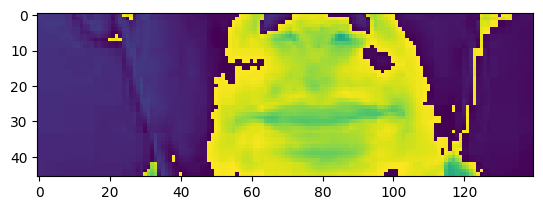

In [14]:
plt.imshow(frames[0])


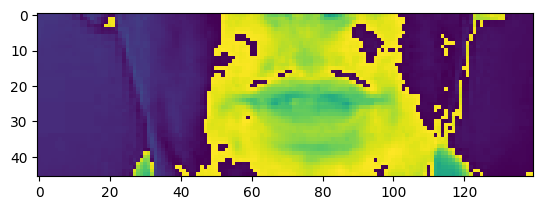

In [15]:
plt.imshow(frames[35])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0,  6,  0, 20, 23, 15,
        0, 14, 15, 23])>

In [17]:
num_to_char(alignments)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'f', b' ', b't', b'w', b'o', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [18]:
# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

##more efficient way to write the above code
tf.strings.reduce_join([num_to_char(x) for x in alignments.numpy()])



<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [19]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### Data PipeLining

In [20]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function )
data = data.padded_batch(2, padded_shapes=([75,None,None,None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(400)
remaining = data.skip(400)
validation = remaining.take(50)
test = remaining.skip(50)


In [21]:
len(test)


50

In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
sample = data.as_numpy_iterator()

In [24]:
val = sample.next()

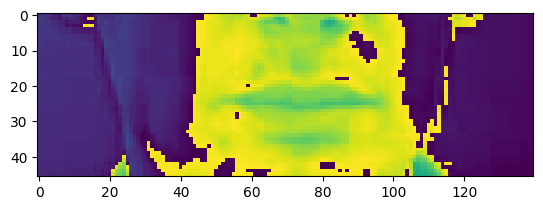

In [25]:
plt.imshow(val[0][0][0])
#0:videos, 0:1st video, 0:1st frame

In [26]:
tf.strings.reduce_join([num_to_char(x) for x in val[1][0]])
#1:alignments, 0: alignments for 1stvideo

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t zero please             '>

### Designing Neural Network

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [28]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [29]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [30]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

### Training

In [31]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [32]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [33]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [40]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=CTCLoss, metrics=['accuracy'])


In [35]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)


In [36]:
schedule_callback = LearningRateScheduler(scheduler)


In [37]:
example_callback = ProduceExample(test)


In [ ]:
model.fit(train, validation_data=validation, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])


### Predictions

In [42]:
test_data = test.as_numpy_iterator()


In [66]:
sample = test_data.next()

In [45]:
yhat = model.predict(sample[0])


1/1 [==============================] - 5s 5s/step


In [53]:
print('REAL TEXT')
for sentence in sample[1]:
    char_list = [num_to_char(word) for word in sentence]
    joined_string = tf.strings.reduce_join(char_list, axis=-1)
    real_text = joined_string.numpy().decode('utf-8')
    print(real_text)

REAL TEXT
bin blue by z nine soon                 
place red at x zero please              


In [47]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [52]:
print('PREDICTIONS')
decoded_sentences = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
for x in decoded_sentences:
    string = x.numpy().decode('utf-8')
    for char in string:
        print(' ' if char == '0' else char, end='')
    print()


PREDICTIONS
bin blue by z nine soon                                                    
place red at x zero please                                                 
